In [1]:
import numpy as np
import pandas as pd
import torch
import os
import re
import json
import pytorch_lightning as L
import itertools

from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch.nn import Linear, Parameter
import torch.nn as nn

from torch.optim import AdamW
from torch import Tensor
from torch.nn import CrossEntropyLoss, L1Loss, MSELoss, ReLU
from sklearn.model_selection import train_test_split

/Users/elenapatyukova/anaconda3/envs/py3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/elenapatyukova/anaconda3/envs/py3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/elenapatyukova/anaconda3/envs/py3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F8622D92-25A9-3A61-A089-C917FDA36C1B> /Users/elenapatyukova/anaconda3/envs/py3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
data_dir='datafiles/'
data_path_train=data_dir+'roost_e_form.csv'

In [3]:
fea_path=data_dir+'onehot-embedding.json'
with open(fea_path,"r") as f:
    elem_features=json.load(f)
elem_emb_len=len(elem_features['H'])

In [4]:
df=pd.read_csv(data_path_train)
df.head()

,material_id,composition,target
0,0,C10000Pt10000,1.995384
1,1,C10000Cd10000,2.103048
2,2,C10000Cd10000,1.983566
3,3,N10000Au10000,1.528850
4,4,C10000Ag10000,2.235059


In [5]:
from Data import data_from_composition

In [6]:
dataset=data_from_composition(df,elem_features)

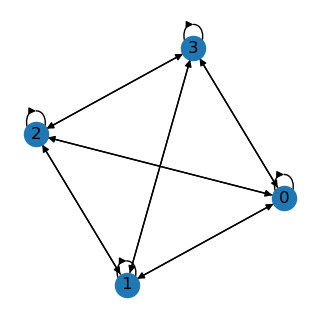

In [7]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

g = to_networkx(dataset[100000], to_undirected=False)
plt.figure(figsize=(3,3))
nx.draw(g, with_labels=True)
plt.show()

In [8]:
config={
      'seed': 0, 
      'model_name': 'roost',
      'epochs': 50,
      'patience': 10,
      'test_size': 0.1,
      'val_size': 0.1,
      'train': True,
      'evaluate': True,
      'data_params': {"batch_size": 128,
                      "pin_memory": False,
                      "shuffle": True,
                      "data_seed": 0},
      'setup_params': {"optim": "AdamW",
                       "learning_rate": 3e-4, #3e-4
                       "weight_decay": 1e-6, #1e-6
                       "momentum": 0.9,
                       "loss": L1Loss}, #0.9
      'model_params': {'input_dim': 112,
                        'output_dim': 1,
                        'hidden_layer_dims': [1024,512,256,128,64],
                        'n_graphs': 3,
                        'elem_heads': 4,
                        'internal_elem_dim': 64,
                        'g_elem_dim': 256,
                        'f_elem_dim': 256,
                        'comp_heads': 4,
                        'g_comp_dim': 256,
                        'f_comp_dim': 256,
                        'batchnorm': False,     
                        'negative_slope': 0.2
                        }
}

In [9]:
index=np.linspace(0,len(dataset)-1,len(dataset),dtype=int)
train_idx,test_idx= train_test_split(index, test_size=config['test_size'], random_state=42)
train_idx,val_idx= train_test_split(train_idx, test_size=config['val_size'], random_state=42)
val_set = torch.utils.data.Subset(dataset, val_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)
train_set = torch.utils.data.Subset(dataset, train_idx)
train_loader = DataLoader(train_set, batch_size=config['data_params']['batch_size'])
val_loader = DataLoader(val_set, batch_size=config['data_params']['batch_size'])
test_loader = DataLoader(test_set, batch_size=1)

In [10]:
from Model import Roost

from torch.nn import L1Loss
import torch.nn.functional as F
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from torchmetrics.functional import mean_squared_error, mean_absolute_error

In [11]:
from torch_geometric.nn import summary

model_vis=Roost(**config['model_params'])
data=dataset[100000]
print(summary(model_vis, data.x, data.edge_index, data.pos))

+----------------------------------------------+------------------------+----------------+-----------+
| Layer                                        | Input Shape            | Output Shape   | #Param    |
|----------------------------------------------+------------------------+----------------+-----------|
| Roost                                        | [4, 112], [2, 16], [4] | [1]            | 2,716,561 |
| ├─(material_nn)DescriptorNetwork             | [4, 112], [2, 16], [4] | [64]           | 1,190,800 |
| │    └─(project_fea)Linear                   | [4, 112]               | [4, 63]        | 7,056     |
| │    └─(graphs)ModuleList                    | --                     | --             | 986,112   |
| │    │    └─(0)GATRoostLayer                 | [4, 64], [2, 16], [4]  | [4, 64]        | 328,704   |
| │    │    └─(1)GATRoostLayer                 | [4, 64], [2, 16], [4]  | [4, 64]        | 328,704   |
| │    │    └─(2)GATRoostLayer                 | [4, 64], [2, 16], [4]  |

In [13]:
class RoostLightning(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = Roost(**config['model_params'])
        self.loss_module=L1Loss()
    
    def forward(self, batch):
        return self.model(batch.x, batch.edge_index, batch.pos, batch.batch)

    def configure_optimizers(self):
        # We use AdamW optimizer with MultistepLR scheduler as in the original Roost model
        optimizer = torch.optim.AdamW(self.parameters(),lr=config['setup_params']['learning_rate'], 
                                      weight_decay=config['setup_params']['weight_decay']) 
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.3)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        _, loss, mae, rmse = self._get_preds_loss_mae_rmse(batch, batch_idx)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=config['data_params']['batch_size'])
        self.log("train_mae", mae, on_step=True, on_epoch=True, prog_bar=True, logger=True,batch_size=config['data_params']['batch_size'])
        self.log("train_rmse", rmse, on_step=True, on_epoch=True, prog_bar=True, logger=True,batch_size=config['data_params']['batch_size'])
        return loss

    def validation_step(self, batch, batch_idx):
        _, loss, mae, rmse = self._get_preds_loss_mae_rmse(batch, batch_idx)
        self.log("val_loss", loss,  on_epoch=True, logger=True,batch_size=config['data_params']['batch_size'])
        self.log("val_mae", mae, on_epoch=True, logger=True,batch_size=config['data_params']['batch_size'])
        self.log("val_rmse", rmse,  on_epoch=True,logger=True,batch_size=config['data_params']['batch_size'])

    def test_step(self, batch, batch_idx):
        pred , loss, mae, rmse = self._get_preds_loss_mae_rmse(batch, batch_idx)
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=config['data_params']['batch_size'])
        self.log("test_mae", mae, on_step=True, on_epoch=True, prog_bar=True, logger=True,batch_size=config['data_params']['batch_size'])
        self.log("test_rmse", rmse, on_step=True, on_epoch=True, prog_bar=True, logger=True,batch_size=config['data_params']['batch_size'])
        return pred, loss, mae, rmse

    def _get_preds_loss_mae_rmse(self, batch, batch_idx):
        '''convenience function since train/valid/test steps are similar'''
        y = batch.y
        pred = self.forward(batch)
        loss = self.loss_module(pred, y)
        mae=mean_absolute_error(pred, y)
        rmse=mean_squared_error(pred, y, squared=False)
        return pred, loss, mae, rmse

In [16]:
from pytorch_lightning.callbacks import ModelCheckpoint
L.seed_everything(42)
# sets seeds for numpy, torch and python.random.
model = RoostLightning(**config)
trainer = Trainer(deterministic=True, max_epochs=50, 
                  callbacks=[ModelCheckpoint(monitor='val_mae', mode='min')])

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,train_dataloaders=train_loader, val_dataloaders=val_loader)


  | Name        | Type   | Params
---------------------------------------
0 | model       | Roost  | 2.7 M 
1 | loss_module | L1Loss | 0     
---------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.866    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/elenapatyukova/anaconda3/envs/py3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [19]:
trainer.save_checkpoint("checkpoints/final_model.ckpt")

In [32]:
path="checkpoints/final_model.ckpt"
result=trainer.test(model,ckpt_path=path,dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Roost/roost/Roost/5clp27fq/checkpoints/epoch=45-step=38686.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Roost/roost/Roost/5clp27fq/checkpoints/epoch=45-step=38686.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.10737301409244537    │
│      test_mae_epoch       │    0.10737301409244537    │
│      test_rmse_epoch      │    0.10737301409244537    │
└───────────────────────────┴───────────────────────────┘